In [1]:
#!/usr/bin/env python
# NFL Spread Prediction Model using XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
import shap
from datetime import datetime, timedelta
import re
import nfl_data_py as nfl

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
# ---- Data Collection ----

def load_nflfastR_data(years):
    """Load NFL data for specified years using nflfastR through Python"""
    import os
    import requests
    from io import StringIO
    
    all_data = []
    
    for year in years:
        print(f"Loading data for {year} season...")
        url = f"https://github.com/nflverse/nflfastR-data/raw/master/data/play_by_play_{year}.csv.gz"
        
        response = requests.get(url)
        if response.status_code == 200:
            data = pd.read_csv(StringIO(response.content.decode('utf-8')))
            all_data.append(data)
        else:
            print(f"Failed to load data for {year}")
    
    return pd.concat(all_data, ignore_index=True)

# Load last 5 seasons
seasons = list(range(2014, 2024))
pbp_data = nfl.import_pbp_data(seasons)

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
# ---- Data Preparation ----

# Extract game-level information
game_data = pbp_data[~pbp_data['spread_line'].isna()].groupby(['game_id', 'home_team', 'away_team', 'season', 'week']).agg({
    'home_score': 'max',
    'away_score': 'max',
    'spread_line': 'first',
    'total_line': 'first',
    'game_date': 'first',
    'roof': 'first',
    'surface': 'first',
    'temp': 'mean',
    'wind': 'mean'
}).reset_index()

# Calculate whether the home team covered the spread
game_data['score_diff'] = game_data['home_score'] - game_data['away_score']
game_data['home_favorite'] = game_data['spread_line'] < 0

# Calculate home team cover result (1 = covered, 0 = didn't cover)
game_data['home_covered'] = np.where(
    game_data['spread_line'] < 0,  # Home team is favorite (negative spread)
    game_data['score_diff'] > abs(game_data['spread_line']),  # Cover if win by more than spread
    game_data['score_diff'] > -game_data['spread_line']  # Cover if lose by less than spread
)

# Determine favored team
game_data['favored_team'] = np.where(game_data['spread_line'] < 0, game_data['home_team'], game_data['away_team'])
game_data['game_date'] = pd.to_datetime(game_data['game_date'])

In [5]:
# ---- Team Performance Metrics ----

def calculate_rolling_stats(games_df, window=5):
    """Calculate rolling performance metrics for each team"""
    all_teams = pd.unique(list(games_df['home_team']) + list(games_df['away_team']))
    team_stats_list = []
    
    for team in all_teams:
        # Get games where team played (both home and away)
        home_games = games_df[games_df['home_team'] == team].copy()
        away_games = games_df[games_df['away_team'] == team].copy()
        
        # Create dataframe for team games
        home_games['team_is_home'] = True
        home_games['team_score'] = home_games['home_score']
        home_games['opponent_score'] = home_games['away_score']
        home_games['opponent'] = home_games['away_team']
        home_games['team_covered'] = home_games['home_covered']
        
        away_games['team_is_home'] = False
        away_games['team_score'] = away_games['away_score']
        away_games['opponent_score'] = away_games['home_score']
        away_games['opponent'] = away_games['home_team']
        away_games['team_covered'] = ~away_games['home_covered'].astype(bool)
        
        # Combine and sort by date
        team_games = pd.concat([home_games, away_games])
        team_games = team_games.sort_values('game_date')
        
        # Add team identifier
        team_games['team'] = team
        
        # Calculate point differentials and other stats
        team_games['pts_diff'] = team_games['team_score'] - team_games['opponent_score']
        
        # Calculate rolling stats
        team_games['roll_pts_scored'] = team_games['team_score'].rolling(window=window, min_periods=1).mean()
        team_games['roll_pts_allowed'] = team_games['opponent_score'].rolling(window=window, min_periods=1).mean()
        team_games['roll_pts_diff'] = team_games['pts_diff'].rolling(window=window, min_periods=1).mean()
        team_games['roll_cover_rate'] = team_games['team_covered'].rolling(window=window, min_periods=1).mean()
        
        # Add win/loss streaks
        team_games['win'] = team_games['team_score'] > team_games['opponent_score']
        team_games['roll_win_rate'] = team_games['win'].rolling(window=window, min_periods=1).mean()
        
        team_stats_list.append(team_games)
    
    return pd.concat(team_stats_list)

# Calculate rolling stats
rolling_stats = calculate_rolling_stats(game_data)

In [6]:
# ---- Feature Engineering ----

# Join home team stats
home_stats = rolling_stats[rolling_stats['team_is_home']].copy()
home_cols = ['game_id', 'roll_pts_scored', 'roll_pts_allowed', 'roll_pts_diff', 
             'roll_cover_rate', 'roll_win_rate']
home_stats = home_stats[home_cols].rename(
    columns={col: f'home_{col}' for col in home_cols if col != 'game_id'})

# Join away team stats
away_stats = rolling_stats[~rolling_stats['team_is_home']].copy()
away_cols = ['game_id', 'roll_pts_scored', 'roll_pts_allowed', 'roll_pts_diff', 
             'roll_cover_rate', 'roll_win_rate']
away_stats = away_stats[away_cols].rename(
    columns={col: f'away_{col}' for col in away_cols if col != 'game_id'})

# Merge stats with game data
model_data = game_data.merge(home_stats, on='game_id', how='left')
model_data = model_data.merge(away_stats, on='game_id', how='left')

# Calculate some relative stats
model_data['pts_diff_advantage'] = model_data['home_roll_pts_diff'] - model_data['away_roll_pts_diff']
model_data['cover_rate_advantage'] = model_data['home_roll_cover_rate'] - model_data['away_roll_cover_rate']
model_data['win_rate_advantage'] = model_data['home_roll_win_rate'] - model_data['away_roll_win_rate']

# Adding day of week and month features
model_data['day_of_week'] = model_data['game_date'].dt.dayofweek
model_data['month'] = model_data['game_date'].dt.month

# Create divisional game flag
def same_division(row):
    divisions = {
        'AFC East': ['NE', 'BUF', 'NYJ', 'MIA'],
        'AFC North': ['BAL', 'PIT', 'CLE', 'CIN'],
        'AFC South': ['HOU', 'IND', 'JAX', 'TEN'],
        'AFC West': ['KC', 'LAC', 'LV', 'DEN'],
        'NFC East': ['DAL', 'PHI', 'NYG', 'WAS'],
        'NFC North': ['GB', 'MIN', 'DET', 'CHI'],
        'NFC South': ['TB', 'NO', 'ATL', 'CAR'],
        'NFC West': ['SF', 'LAR', 'SEA', 'ARI']
    }
    
    for division, teams in divisions.items():
        if row['home_team'] in teams and row['away_team'] in teams:
            return 1
    return 0

model_data['divisional_game'] = model_data.apply(same_division, axis=1)

# Add abs_spread_line for model features
model_data['abs_spread_line'] = model_data['spread_line'].abs()

# Drop NA values for modelling
model_data_clean = model_data.dropna()

# ---- Prepare features for model ----

# Select features for the model
feature_cols = [
    'home_roll_pts_scored', 'home_roll_pts_allowed', 'home_roll_pts_diff',
    'home_roll_cover_rate', 'home_roll_win_rate',
    'away_roll_pts_scored', 'away_roll_pts_allowed', 'away_roll_pts_diff',
    'away_roll_cover_rate', 'away_roll_win_rate',
    'pts_diff_advantage', 'cover_rate_advantage', 'win_rate_advantage',
    'abs_spread_line', 'spread_line', 'total_line',
    'divisional_game', 'day_of_week', 'month'
]

# Convert categorical features to dummies if needed
categorical_features = ['day_of_week', 'month']

# Define features and target
X = model_data_clean[feature_cols]
y = model_data_clean['home_covered'].astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Train Accuracy: 0.9006
Test Accuracy: 0.8822

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       153
           1       0.88      0.93      0.90       212

    accuracy                           0.88       365
   macro avg       0.88      0.87      0.88       365
weighted avg       0.88      0.88      0.88       365



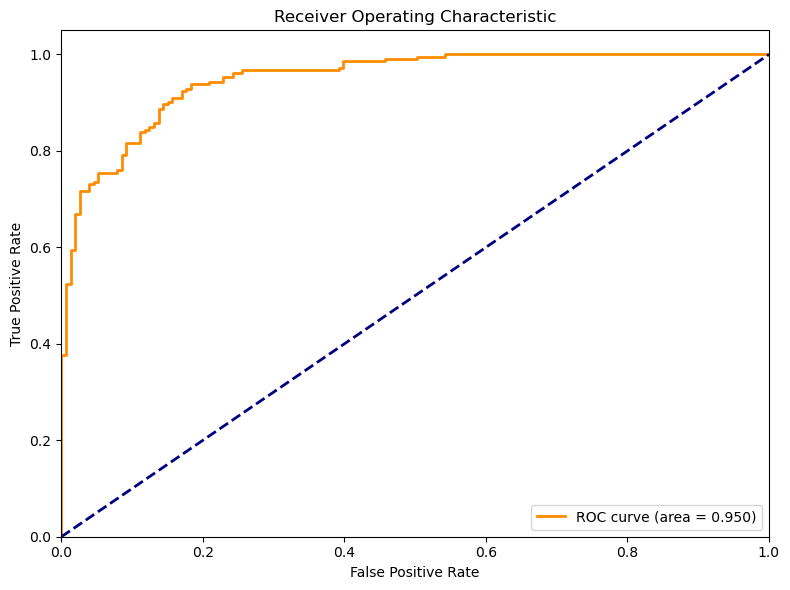

In [7]:
# ---- Train XGBoost Model ----

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

# Create preprocessing for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Get predictions
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

# ---- Model Evaluation ----

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Cover', 'Covered'],
            yticklabels=['Did Not Cover', 'Covered'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

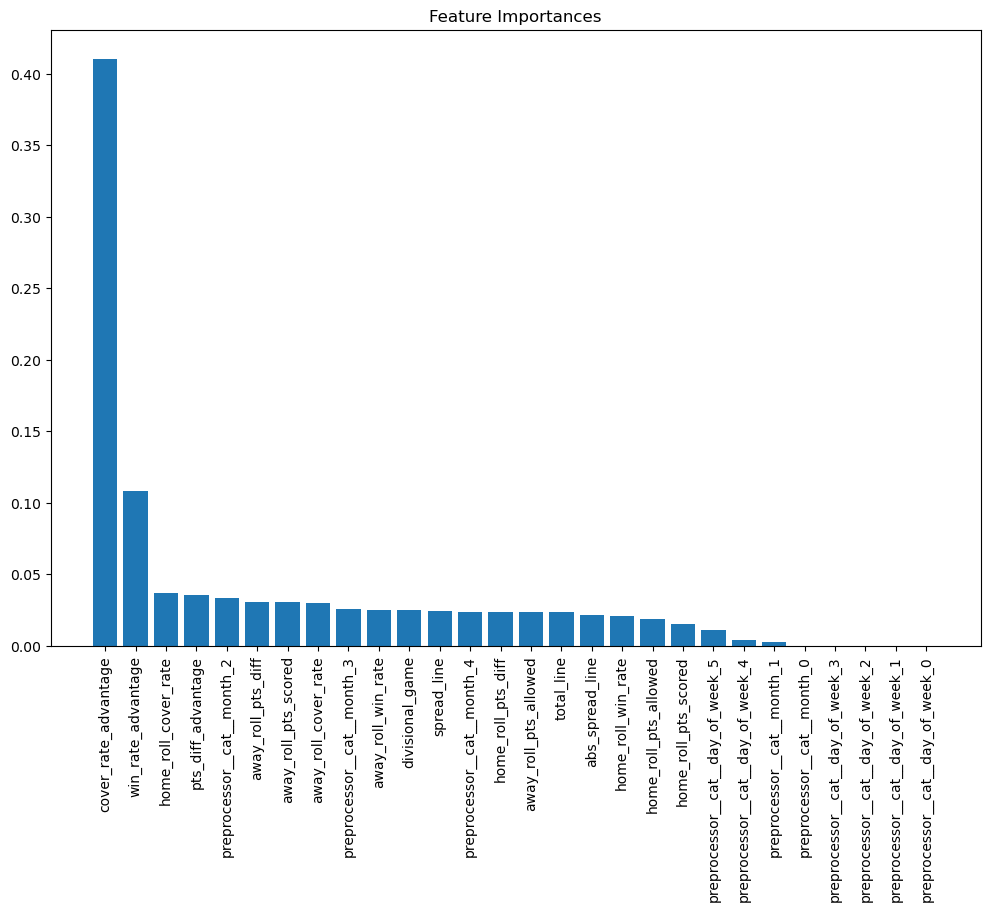

In [9]:
# ---- Feature Importance ----

# Get feature names after preprocessing
preprocessor.fit(X_train)

# Create feature names for categorical features after one-hot encoding
cat_feature_names = []
for i, col in enumerate(categorical_features):
    # Get number of unique values in each categorical column
    n_categories = model_data_clean[col].nunique() - 1
    # Create a name for each category (except the reference category that's dropped)
    for j in range(n_categories):
        cat_feature_names.append(f'preprocessor__cat__{col}_{j}')

# Combine with numerical feature names
feature_names = cat_feature_names + [col for col in X_train.columns if col not in categorical_features]

# Get feature importances
importances = pipeline.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.show()

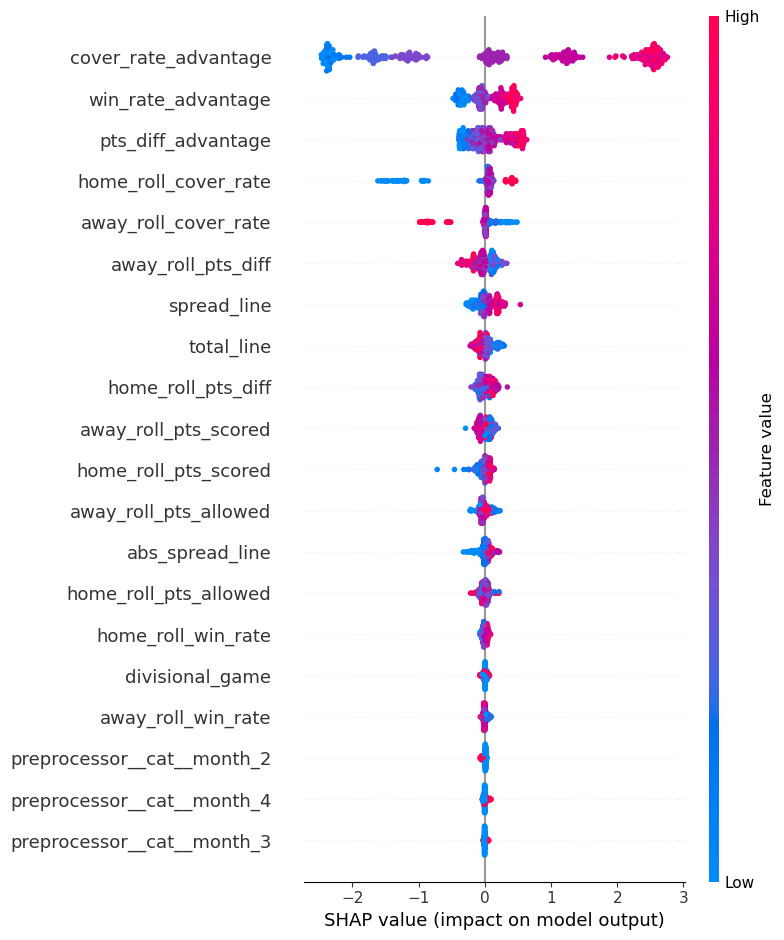

<Figure size 2000x300 with 0 Axes>

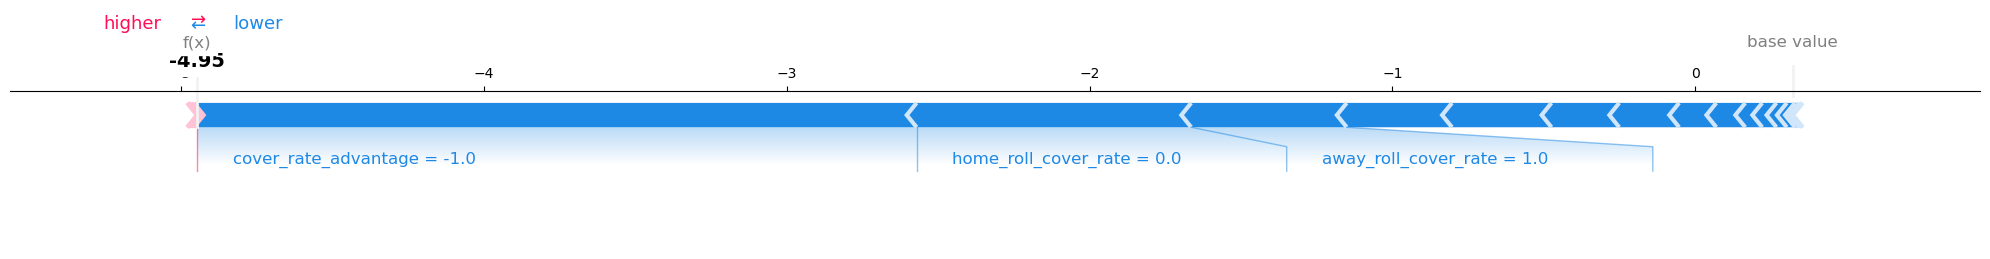

In [10]:
# ---- SHAP Values for Interpretability ----

# Create explainer
explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(preprocessor.transform(X_test))

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, preprocessor.transform(X_test), 
                 feature_names=feature_names,
                 show=False)
plt.tight_layout()
plt.show()

# Force plot for a single prediction (first test example)
plt.figure(figsize=(20, 3))
shap.force_plot(
    explainer.expected_value, 
    shap_values[0,:], 
    preprocessor.transform(X_test.iloc[0:1,:]),
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.show()

In [11]:
# ---- Model Application Function ----

def predict_spread_cover(pipeline, home_team, away_team, spread_line, 
                        home_stats_dict, away_stats_dict, 
                        game_date=None, is_divisional=None, total_line=None):
    """
    Make a prediction for a specific matchup
    
    Parameters:
    -----------
    pipeline: trained model pipeline
    home_team: home team abbreviation
    away_team: away team abbreviation
    spread_line: current spread line (negative means home is favored)
    home_stats_dict: dictionary with home team's rolling stats
    away_stats_dict: dictionary with away team's rolling stats
    game_date: datetime object for the game (optional)
    is_divisional: whether it's a divisional game (optional)
    total_line: over/under line (optional)
    
    Returns:
    --------
    Dictionary with prediction results
    """
    if game_date is None:
        game_date = datetime.now()
    
    # Create feature dataframe
    features = pd.DataFrame({
        'home_roll_pts_scored': [home_stats_dict.get('roll_pts_scored', 0)],
        'home_roll_pts_allowed': [home_stats_dict.get('roll_pts_allowed', 0)],
        'home_roll_pts_diff': [home_stats_dict.get('roll_pts_diff', 0)],
        'home_roll_cover_rate': [home_stats_dict.get('roll_cover_rate', 0.5)],
        'home_roll_win_rate': [home_stats_dict.get('roll_win_rate', 0.5)],
        'away_roll_pts_scored': [away_stats_dict.get('roll_pts_scored', 0)],
        'away_roll_pts_allowed': [away_stats_dict.get('roll_pts_allowed', 0)],
        'away_roll_pts_diff': [away_stats_dict.get('roll_pts_diff', 0)],
        'away_roll_cover_rate': [away_stats_dict.get('roll_cover_rate', 0.5)],
        'away_roll_win_rate': [away_stats_dict.get('roll_win_rate', 0.5)],
        'pts_diff_advantage': [home_stats_dict.get('roll_pts_diff', 0) - 
                              away_stats_dict.get('roll_pts_diff', 0)],
        'cover_rate_advantage': [home_stats_dict.get('roll_cover_rate', 0.5) - 
                                away_stats_dict.get('roll_cover_rate', 0.5)],
        'win_rate_advantage': [home_stats_dict.get('roll_win_rate', 0.5) - 
                              away_stats_dict.get('roll_win_rate', 0.5)],
        'abs_spread_line': [abs(spread_line)],
        'spread_line': [spread_line],
        'total_line': [total_line if total_line is not None else 44.5],  # Default if not provided
        'divisional_game': [1 if is_divisional else 0 if is_divisional is not None else 0],
        'day_of_week': [game_date.weekday()],
        'month': [game_date.month]
    })
    
    # Make prediction
    cover_prob = pipeline.predict_proba(features)[0, 1]
    prediction = 1 if cover_prob > 0.5 else 0
    
    # Create result dictionary
    result = {
        'home_team': home_team,
        'away_team': away_team,
        'spread_line': spread_line,
        'home_cover_probability': cover_prob,
        'prediction': 'Home team covers' if prediction == 1 else 'Home team does not cover',
        'confidence': max(cover_prob, 1 - cover_prob)
    }
    
    return result

# Example usage:
"""
# Example: Predict if Patriots will cover the spread against the Chiefs
patriots_stats = {
    'roll_pts_scored': 21.4,
    'roll_pts_allowed': 20.2,
    'roll_pts_diff': 1.2,
    'roll_cover_rate': 0.6,
    'roll_win_rate': 0.6
}

chiefs_stats = {
    'roll_pts_scored': 28.5,
    'roll_pts_allowed': 22.3,
    'roll_pts_diff': 6.2,
    'roll_cover_rate': 0.7,
    'roll_win_rate': 0.8
}

prediction = predict_spread_cover(
    pipeline=pipeline,
    home_team='NE',
    away_team='KC',
    spread_line=3.5,  # Patriots are 3.5-point underdogs
    home_stats_dict=patriots_stats,
    away_stats_dict=chiefs_stats,
    game_date=datetime.now(),
    is_divisional=False,
    total_line=47.5
)

print(prediction)
"""

"\n# Example: Predict if Patriots will cover the spread against the Chiefs\npatriots_stats = {\n    'roll_pts_scored': 21.4,\n    'roll_pts_allowed': 20.2,\n    'roll_pts_diff': 1.2,\n    'roll_cover_rate': 0.6,\n    'roll_win_rate': 0.6\n}\n\nchiefs_stats = {\n    'roll_pts_scored': 28.5,\n    'roll_pts_allowed': 22.3,\n    'roll_pts_diff': 6.2,\n    'roll_cover_rate': 0.7,\n    'roll_win_rate': 0.8\n}\n\nprediction = predict_spread_cover(\n    pipeline=pipeline,\n    home_team='NE',\n    away_team='KC',\n    spread_line=3.5,  # Patriots are 3.5-point underdogs\n    home_stats_dict=patriots_stats,\n    away_stats_dict=chiefs_stats,\n    game_date=datetime.now(),\n    is_divisional=False,\n    total_line=47.5\n)\n\nprint(prediction)\n"

In [12]:
# ---- Model Storage ----

# Save the model
import joblib
joblib.dump(pipeline, 'nfl_spread_prediction_model.pkl')

print("Model saved as 'nfl_spread_prediction_model.pkl'")
print("\nTo use the model for predictions:")
print("1. Load the model: pipeline = joblib.load('nfl_spread_prediction_model.pkl')")
print("2. Use the predict_spread_cover() function with team stats")

Model saved as 'nfl_spread_prediction_model.pkl'

To use the model for predictions:
1. Load the model: pipeline = joblib.load('nfl_spread_prediction_model.pkl')
2. Use the predict_spread_cover() function with team stats


### Predictions

In [17]:
import pandas as pd
from datetime import datetime

def compute_stats_from_nflfastr(df, window=5):
    """
    Computes rolling stats for a team using nflfastR-style game-level data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Subset of nflfastR data for a team in 2025. Should include:
        - 'points': team's points
        - 'opp_points': opponent's points
        - 'spread_line': closing spread (positive = underdog)
        - 'result': 'W', 'L', or 'T'

    window : int
        Number of games to use for rolling stats.
    
    Returns:
    --------
    dict : Rolling stat values.
    """
    df = df.copy().tail(window)
    pts_scored = df['points'].mean()
    pts_allowed = df['opp_points'].mean()
    pts_diff = pts_scored - pts_allowed
    win_rate = (df['result'] == 'W').mean()
    
    # Create "covered spread" column
    df['covered'] = ((df['points'] + df['spread_line']) > df['opp_points']).astype(int)
    cover_rate = df['covered'].mean()
    
    return {
        'roll_pts_scored': pts_scored,
        'roll_pts_allowed': pts_allowed,
        'roll_pts_diff': pts_diff,
        'roll_cover_rate': cover_rate,
        'roll_win_rate': win_rate
    }


def predict_spread_cover(pipeline, home_team, away_team, spread_line, 
                         home_df, away_df, game_date=None, 
                         is_divisional=None, total_line=None, window=5):
    """
    Predict if the home team will cover the spread using recent team stats.
    
    Parameters:
    -----------
    pipeline : trained sklearn pipeline
    home_team : str
        Home team abbreviation (e.g., 'NE')
    away_team : str
        Away team abbreviation (e.g., 'KC')
    spread_line : float
        Vegas spread (negative = home favored)
    home_df : pd.DataFrame
        Filtered nflfastR 2025 data for the home team
    away_df : pd.DataFrame
        Filtered nflfastR 2025 data for the away team
    game_date : datetime
        Optional, for day_of_week and month features
    is_divisional : bool
        Whether this is a divisional matchup
    total_line : float
        Over/under line
    window : int
        Rolling window for stats
        
    Returns:
    --------
    dict : Prediction result with probabilities and model inputs.
    """
    if game_date is None:
        game_date = datetime.now()
    
    # Compute rolling stats
    home_stats = compute_stats_from_nflfastr(home_df, window)
    away_stats = compute_stats_from_nflfastr(away_df, window)
    
    # Feature construction
    features = pd.DataFrame({
        'home_roll_pts_scored': [home_stats['roll_pts_scored']],
        'home_roll_pts_allowed': [home_stats['roll_pts_allowed']],
        'home_roll_pts_diff': [home_stats['roll_pts_diff']],
        'home_roll_cover_rate': [home_stats['roll_cover_rate']],
        'home_roll_win_rate': [home_stats['roll_win_rate']],
        'away_roll_pts_scored': [away_stats['roll_pts_scored']],
        'away_roll_pts_allowed': [away_stats['roll_pts_allowed']],
        'away_roll_pts_diff': [away_stats['roll_pts_diff']],
        'away_roll_cover_rate': [away_stats['roll_cover_rate']],
        'away_roll_win_rate': [away_stats['roll_win_rate']],
        'pts_diff_advantage': [home_stats['roll_pts_diff'] - away_stats['roll_pts_diff']],
        'cover_rate_advantage': [home_stats['roll_cover_rate'] - away_stats['roll_cover_rate']],
        'win_rate_advantage': [home_stats['roll_win_rate'] - away_stats['roll_win_rate']],
        'abs_spread_line': [abs(spread_line)],
        'spread_line': [spread_line],
        'total_line': [total_line if total_line is not None else 44.5],
        'divisional_game': [1 if is_divisional else 0],
        'day_of_week': [game_date.weekday()],
        'month': [game_date.month]
    })

    # Predict probability of home covering
    cover_prob = pipeline.predict_proba(features)[0, 1]
    prediction = int(cover_prob > 0.5)

    return {
        'home_team': home_team,
        'away_team': away_team,
        'spread_line': spread_line,
        'home_cover_probability': cover_prob,
        'prediction': 'Home team covers' if prediction else 'Home team does not cover',
        'confidence': max(cover_prob, 1 - cover_prob)
    }


In [22]:
nfl_df_2025 = nfl.import_pbp_data([2024])
trained_pipeline = joblib.load("nfl_spread_prediction_model.pkl")

2024 done.
Downcasting floats.


In [23]:
# Load 2025 subset of nflfastR game-level data
home_df = nfl_df_2025[nfl_df_2025['posteam'] == 'NE']
away_df = nfl_df_2025[nfl_df_2025['posteam'] == 'KC']

result = predict_spread_cover(
    pipeline=trained_pipeline,
    home_team='NE',
    away_team='KC',
    spread_line=3.5,
    home_df=home_df,
    away_df=away_df,
    game_date=datetime(2025, 10, 12),
    is_divisional=False,
    total_line=47.5
)

print(result)

KeyError: 'points'